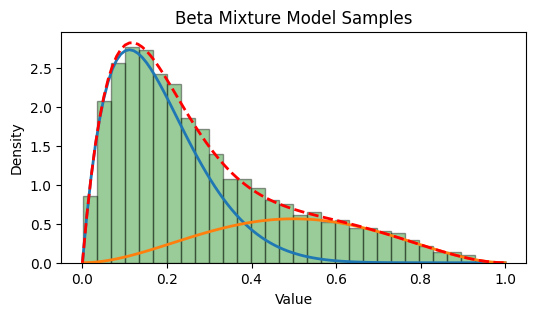

In [7]:
# generate n random data from beta mixture model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def generate_beta_mixture(n, weights, a_params, b_params):
    """
    Generate n random samples from a beta mixture model.

    Parameters:
    n (int): Number of samples to generate.
    weights (list): List of weights for each beta component.
    a_params (list): List of 'a' parameters for each beta component.
    b_params (list): List of 'b' parameters for each beta component.

    Returns:
    np.ndarray: Array of generated samples.
    """
    # Normalize weights
    weights = np.array(weights)
    weights /= weights.sum()

    # Choose components based on weights
    components = np.random.choice(len(weights), size=n, p=weights)
    # print(components)
    # Generate samples
    samples = np.array([beta.rvs(a_params[i], b_params[i]) for i in components])

    return samples
if __name__ == "__main__":
    # Parameters for the beta mixture model
    weights = [0.7, 0.3]
    a_params = [2, 3]
    b_params = [9, 3]

    # Generate samples
    n_samples = 10000
    samples = generate_beta_mixture(n_samples, weights, a_params, b_params)

    # Plot histogram of the samples
    fig = plt.figure(figsize=(6, 3))
    plt.hist(samples, bins=30, density=True, alpha=0.4, \
             color='g', edgecolor='black')

    # Plot the individual beta components for reference
    x = np.linspace(0, 1, 100)
    y = np.zeros_like(x)
    for w, a, b in zip(weights, a_params, b_params):
        y += w * beta.pdf(x, a, b)
        plt.plot(x, w * beta.pdf(x, a, b), lw=2)
    plt.plot(x, y, 'r--', lw=2, label='Mixture PDF')
    plt.title('Beta Mixture Model Samples')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()


True Weights: [0.7, 0.3]
Estimated Weights: [0.75925647 0.24074353]
True a Parameters: [2, 3]
Estimated a Parameters: [1.99087412 3.57839041]
True b Parameters: [9, 3]
Estimated b Parameters: [8.75182647 3.03198468]


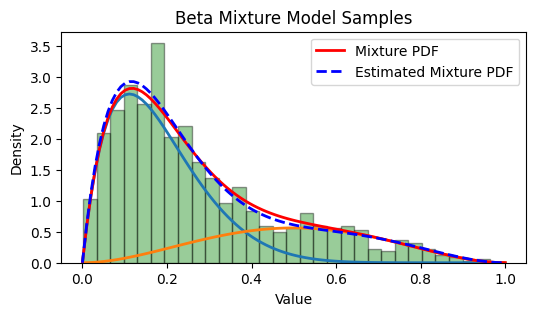

In [45]:
# Estimate the parameters of a beta mixture model using optimize.minimize
from scipy.optimize import minimize
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

def beta_mixture_likelihood(params, weights, a_params, b_params, samples):
    """
    Calculate the negative log-likelihood of the beta mixture model.

    Parameters:
    params (list): List of parameters to optimize (weights, a_params, b_params).
    weights (list): List of weights for each beta component.
    a_params (list): List of 'a' parameters for each beta component.
    b_params (list): List of 'b' parameters for each beta component.
    samples (np.ndarray): Array of observed samples.

    Returns:
    float: Negative log-likelihood value.
    """
    n_components = len(weights)
    likelihood = np.zeros_like(samples)

    for i in range(n_components):
        likelihood += params[i] * beta.pdf(samples, params[n_components + i], params[2 * n_components + i])

    # Avoid log(0) by adding a small constant
    likelihood = np.clip(likelihood, 1e-10, None)
    return -np.sum(np.log(likelihood))
def estimate_beta_mixture(samples, n_components):
    """ Estimate the parameters of a beta mixture model.
    Parameters:
    samples (np.ndarray): Array of observed samples.
    n_components (int): Number of components in the mixture model.
    Returns:
    list: List of estimated parameters (weights, a_params, b_params).
    """
    # Initialize parameters
    weights = np.ones(n_components) / n_components
    a_params = np.ones(n_components)
    b_params = np.ones(n_components)

    # Optimize the parameters
    params0 = np.concatenate((weights, a_params, b_params))
    # Set bounds for weights (0,1) and a,b parameters (>0)    
    bounds = [(0, 1)] * n_components + [(1e-2, None)] * n_components + [(1e-2, None)] * n_components
    # add constraint that weights sum to 1
    const = {'type': 'eq', 'fun': lambda x: np.sum(x[:n_components]) - 1}
    # set options
    options = {'maxiter': 10000, 'disp': False, 'ftol': 1e-6}
    res = minimize(beta_mixture_likelihood, params0, \
                   args=(weights, a_params, b_params, samples), \
                    bounds=bounds, constraints=const, options=options)
    weights, a_params, b_params = res.x[:n_components], res.x[n_components:2*n_components], res.x[2*n_components:]

    return weights, a_params, b_params
if __name__ == "__main__":
    # Generate samples from a beta mixture model
    true_weights = [0.7, 0.3]
    true_a_params = [2, 3]
    true_b_params = [9, 3]
    n_samples = 1000
    samples = generate_beta_mixture(n_samples, true_weights, true_a_params, true_b_params)

    # Estimate the parameters of the beta mixture model
    n_components = 2
    est_weights, est_a_params, est_b_params = estimate_beta_mixture(samples, n_components)

    print("True Weights:", true_weights)
    print("Estimated Weights:", est_weights)
    print("True a Parameters:", true_a_params)
    print("Estimated a Parameters:", est_a_params)
    print("True b Parameters:", true_b_params)
    print("Estimated b Parameters:", est_b_params)

    # Plot histogram of the samples
    fig = plt.figure(figsize=(6, 3))
    plt.hist(samples, bins=30, density=True, alpha=0.4, \
             color='g', edgecolor='black')

    # Plot the individual beta components for reference
    x = np.linspace(0, 1, 100)
    y = np.zeros_like(x)
    y_opt = np.zeros_like(x)
    for w, a, b in zip(true_weights, true_a_params, true_b_params):
        y += w * beta.pdf(x, a, b)
        plt.plot(x, w * beta.pdf(x, a, b), lw=2)

    for w, a, b in zip(est_weights, est_a_params, est_b_params):
        y_opt += w * beta.pdf(x, a, b)
        
    plt.plot(x, y, 'r', lw=2, label='Mixture PDF')
    plt.plot(x, y_opt, 'b--', lw=2, label='Estimated Mixture PDF')
    plt.title('Beta Mixture Model Samples')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

